In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")

In [ ]:
# Load the CIFAR-10 dataset
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
val_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=100, shuffle=False, num_workers=2)
num_classes=10

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Define the neural network architecture
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)
        self.dropout = nn.Dropout(0.5)  # Add dropout layer with 0.5 dropout probability

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)  # Apply dropout to the second fully connected layer
        x = self.fc3(x)
        return x


In [ ]:
# Create an instance of the neural network

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Train ResNet18 model as sanity check (Variance=0 because there is no dropout layer)
# model = torchvision.models.resnet18().to(device)
# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, num_classes)
# model = model.to(device)

model = Net().to(device)

In [ ]:
# The model outputs logit i.e., the unnormalised (or not-yet normalised) predictions. The softmax part is implemented in nn.CELoss

In [ ]:
# Define the training parameters
learning_rate = 0.001
num_epochs = 15

In [ ]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# Lists to store training and validation metrics
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (images, labels) in enumerate(train_dataloader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    # Calculate training accuracy and loss
    train_accuracy = 100 * correct / total
    train_loss = running_loss / len(train_dataloader)

    # Evaluation on validation set
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            val_loss += criterion(outputs, labels).item()

            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    # Calculate validation accuracy and loss
    val_accuracy = 100 * val_correct / val_total
    val_loss /= len(val_dataloader)

    print(f"Epoch [{epoch + 1}/{num_epochs}], "
          f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, "
          f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # Store metrics in lists
    train_loss_list.append(train_loss)
    train_acc_list.append(train_accuracy)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_accuracy)

Epoch [1/15], Training Loss: 1.8245, Training Accuracy: 32.78%, Validation Loss: 1.5455, Validation Accuracy: 43.71%
Epoch [2/15], Training Loss: 1.5270, Training Accuracy: 45.02%, Validation Loss: 1.3861, Validation Accuracy: 49.16%
Epoch [3/15], Training Loss: 1.4139, Training Accuracy: 49.62%, Validation Loss: 1.3245, Validation Accuracy: 52.24%
Epoch [4/15], Training Loss: 1.3372, Training Accuracy: 52.43%, Validation Loss: 1.2623, Validation Accuracy: 54.53%
Epoch [5/15], Training Loss: 1.2704, Training Accuracy: 55.15%, Validation Loss: 1.2276, Validation Accuracy: 56.26%
Epoch [6/15], Training Loss: 1.2197, Training Accuracy: 57.22%, Validation Loss: 1.1585, Validation Accuracy: 58.20%
Epoch [7/15], Training Loss: 1.1626, Training Accuracy: 59.52%, Validation Loss: 1.1498, Validation Accuracy: 59.24%
Epoch [8/15], Training Loss: 1.1214, Training Accuracy: 61.12%, Validation Loss: 1.1424, Validation Accuracy: 59.59%
Epoch [9/15], Training Loss: 1.0837, Training Accuracy: 62.27%, 

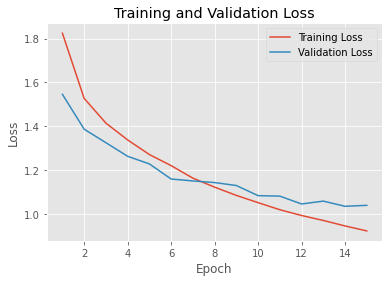

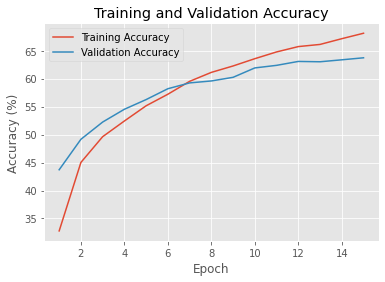

In [ ]:
# Plot the training and validation loss curves
plt.figure()
plt.plot(range(1, num_epochs + 1), train_loss_list, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy curves
plt.figure()
plt.plot(range(1, num_epochs + 1), train_acc_list, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_acc_list, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Loss and Accuracy on Validation set it better than on Training set because of dropout

In [ ]:
# Define a function for Monte Carlo Dropout inference
def monte_carlo_dropout_inference(model, dataloader, num_samples, num_classes):
    model.train()
    predictions = []
    with torch.no_grad():
        for images, _ in dataloader:
            images = images.to(device)
            outputs = torch.zeros((num_samples, images.size(0), num_classes)).to(device)

            # For each batch in the dataloader, 'num_samples' predictions are being made
            for i in range(num_samples):
                outputs[i] = model(images)

            # Apply softmax to all 'num_samples' predictions made for that batch, then store them.
            predictions.append(outputs.softmax(dim=-1).cpu().numpy())

    return np.array(predictions)

In [ ]:
# Perform Monte Carlo Dropout inference
num_samples = 50
predictions = monte_carlo_dropout_inference(model, val_dataloader, num_samples, num_classes)

In [ ]:
print(predictions.shape)
# (Number of batches in dataloader, Number of Monte Carlo samples, Number of images in each batch, Number of class)

(100, 50, 100, 10)


In [ ]:
# Calculate predictive mean and variance for each batch of samples
mean_predictions = torch.mean(torch.tensor(predictions), dim=1)
var_predictions = torch.var(torch.tensor(predictions), dim=1)

In [ ]:
print(mean_predictions.shape)

torch.Size([100, 100, 10])


In [ ]:
def transform_image(image):
    # Min-max scaling to transform image tensor from -1 to 1 to 0 to 1
    image_min = np.min(image)
    image_max = np.max(image)
    transformed_image = (image - image_min) / (image_max - image_min)
    return transformed_image

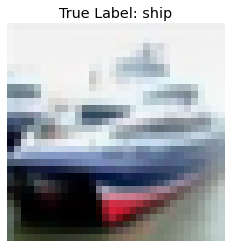

In [ ]:
# Show uncertainty estimates for a random image
image_index = 1
batch_index = 0

class_names = val_dataset.classes
image = val_dataset[image_index][0]  # Get the image tensor
true_label = class_names[val_dataset[image_index][1]]  # Get the true label

# Convert the image tensor to a NumPy array and transpose the dimensions
image = np.transpose(image.numpy(), (1, 2, 0))

# Plot the image
plt.imshow(transform_image(image))
plt.axis('off')
plt.title('True Label: ' + true_label)
plt.show()


In [ ]:
# Display uncertainty estimates for each class
for i in range(10):
    class_name = class_names[i]
    mean_prediction = mean_predictions[batch_index][image_index][i]
    variance_prediction = var_predictions[batch_index][image_index][i]
    print(f"{class_name} - Mean: {mean_prediction}, Variance: {variance_prediction}")

airplane - Mean: 0.12187597155570984, Variance: 0.005583256017416716
automobile - Mean: 0.007160446140915155, Variance: 0.001296928501687944
bird - Mean: 0.0002537656982894987, Variance: 9.451585469832935e-07
cat - Mean: 0.00013439425674732774, Variance: 3.4287481298633793e-07
deer - Mean: 0.0002141123841283843, Variance: 1.5350761941590463e-06
dog - Mean: 1.0196152288699523e-05, Variance: 2.065234872006272e-09
frog - Mean: 2.2452325083577307e-06, Variance: 5.5234691820338355e-11
horse - Mean: 3.4161421353928745e-06, Variance: 5.481561871079066e-10
ship - Mean: 0.8697699904441833, Variance: 0.0074423933401703835
truck - Mean: 0.000575594836845994, Variance: 3.400572040845873e-06


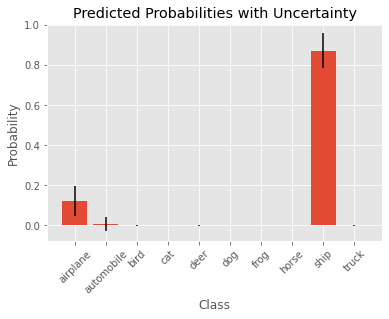

In [ ]:
# Visualize the uncertainty for each class
plt.figure()
plt.bar(class_names, mean_predictions[batch_index][image_index], yerr=np.sqrt(var_predictions[batch_index][image_index]))
plt.xlabel('Class')
plt.ylabel('Probability')
plt.title('Predicted Probabilities with Uncertainty')
plt.xticks(rotation=45)
plt.show()


In [ ]:
'''
Notes from MIT 6.S191: Uncertainty in Deep Learning

Q. What do we mean by Uncertainty?
->  Return a distribution over predictions rather than a single prediction
    For Classification, this could mean reporting the output label along with its confidence
    For Regression, this could mean reporting the output mean along with its variance
    But the general idea is, that uncertainty estimates quantify when we can trust the model's predictions

Q.  How do we measure the quality of Uncertainty?
->  There are multiple ways to do this, one is, Calibration Error = |Confidence - Accuracy|, where Confidence = Predicted Probability, and Accuracy = Observed Frequency of Correctness (given a picture of a cat x times, what percrentage of times did it predict cat correctly)
'''

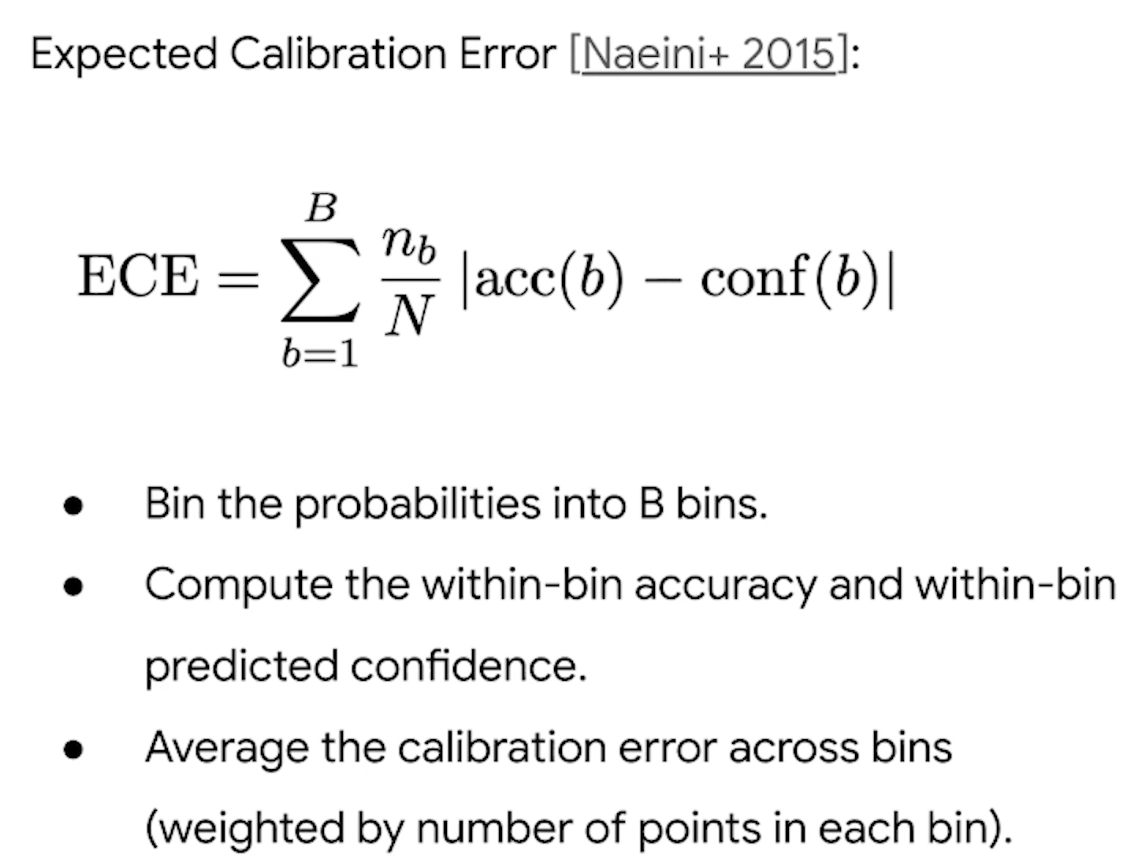